In [1]:
# imports of necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define some key functions 

In [2]:
def statebreaker(city_state):
    """
    Params:  
    city_state - A string consisting of a city name and a state abbreviation
    
    Function:  
    Splits the string, extracting the state abbreviation.
    """
    split_list = city_state.split(',')
    return split_list[-1]


def delay_binarizer(input_col):
    
    """
    Params:
    input_col - an input of time in minutes
    
    Function:
    Returns 0 if the time is positive (delayed) or 1 if the flight is early/on time"""
    if input_col > 0:
        return 0
    else:
        return 1

    
def get_hour(time):
    
    """
    Params - A time in format HHMM.0
    
    Returns  the two digits representing the hour of the flight
    """
    
    s = str(int(time))
    if len(s) <= 2:
        return 0
    else:
        return int(s[:-2])

In [3]:

def get_min(time):
    
    """
    Params - A time in format HHMM.0
    
    Returns  the two digits representing the minutes of the flight
    """
    s = str(int(time))
    if len(s) <=2:
        return(int(s))
    else:
        return (int(s[-2:]))

def haul_type(elapsed_time):
    
    """
    Params - Duration of a flight
    
    Returns -  A haul type as defined below:
    
        Short - Less than 180 minutes
        Medium - Between 180 and 360 minutes
        Long - Over 360 minutes
     """
    if elapsed_time < 180:
        return 'Short'
    elif 180 < elapsed_time < 360:
        return 'Medium'
    else:
        return 'Long'

## Exploratory Data Analysis

Use this notebook to get familiar with the datasets we have. There is 10 questions we need to answer during the EDA.

* Check the cumulative delay minutes per tail number.  Do some planes have a higher tendency to be late due to mechanical issues.  --- YES!!!!
* Do certain carriers have a higher likelihood of delays than others? Do certain airports? Flight numbers?
* What time of day do most delays occur?
* Weather, weather, weather

## Columns to Drop

* Flights - There is only one value in thw whole table
* All 5 features with the _delay tag
* OP_carrier_fl_num, op_unique_carrier
* Taxi in, Taxi Out
* branded_code_share
* origin_airport_id, dest_airport_id
* Wheels_off, wheels_on
* Cancelled, cancellation code
* Diverted

## Feature Addition

* Split fl_date into day, month, year
* Created columns for departure state and destination state
* Created a column called flight_time_change representing the change in actual vs expected flight time
* Split the crs_dep_time column into dep_hour and dep_minute for analysis
* Created a haul_type column where flight times are classified as long, short or medium haul
* Plane, airline and airport on-time percentages
* Weather Severity
* Weather conditions



In [4]:
data = pd.read_csv('data/flights_weather.csv', low_memory=False)

In [5]:
# Let's get a sense of the data
data.head()

,Unnamed: 0,Unnamed: 0.1,fl_date,mkt_unique_carrier,branded_code_share,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,op_carrier_fl_num,...,dep_hour,arr_hour,dep_period,arr_period,origin_match_code,dest_match_code,origin_weather_condition,origin_weather_severity,dest_weather_condition,dest_weather_severity
0,0,0,2019-01-01,AA,AA_CODESHARE,AA,5606,OH,N575NN,5606,...,21,23,Evening,Evening,MYR2019-01-01Evening,CLT2019-01-01Evening,Clear,Light,Clear,Light
1,1,1,2019-01-01,AA,AA_CODESHARE,AA,5607,OH,N254PS,5607,...,11,13,Morning,Afternoon,BDL2019-01-01Morning,DCA2019-01-01Afternoon,Rain,Moderate,Clear,Light
2,2,2,2019-01-01,AA,AA_CODESHARE,AA,5607,OH,N254PS,5607,...,10,11,Morning,Morning,DCA2019-01-01Morning,BDL2019-01-01Morning,Rain,Light,Rain,Moderate
3,3,3,2019-01-01,AA,AA_CODESHARE,AA,5608,OH,N710PS,5608,...,20,21,Evening,Evening,DCA2019-01-01Evening,GSP2019-01-01Evening,Clear,Light,Clear,Light
4,4,4,2019-01-01,AA,AA_CODESHARE,AA,5610,OH,N515AE,5610,...,12,13,Afternoon,Afternoon,ORF2019-01-01Afternoon,CLT2019-01-01Afternoon,Clear,Light,Clear,Light


In [6]:
data.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'fl_date', 'mkt_unique_carrier',
       'branded_code_share', 'mkt_carrier', 'mkt_carrier_fl_num',
       'op_unique_carrier', 'tail_num', 'op_carrier_fl_num',
       'origin_airport_id', 'origin', 'origin_city_name', 'dest_airport_id',
       'dest', 'dest_city_name', 'crs_dep_time', 'dep_time', 'dep_delay',
       'taxi_out', 'wheels_off', 'wheels_on', 'taxi_in', 'crs_arr_time',
       'arr_time', 'arr_delay', 'cancelled', 'cancellation_code', 'diverted',
       'dup', 'crs_elapsed_time', 'actual_elapsed_time', 'air_time', 'flights',
       'distance', 'carrier_delay', 'weather_delay', 'nas_delay',
       'security_delay', 'late_aircraft_delay', 'first_dep_time',
       'total_add_gtime', 'longest_add_gtime', 'no_name', 'dep_hour',
       'arr_hour', 'dep_period', 'arr_period', 'origin_match_code',
       'dest_match_code', 'origin_weather_condition',
       'origin_weather_severity', 'dest_weather_condition',
       'dest_weather_severity'],
    

In [7]:
data.dep_delay.describe()

count    1.317705e+06
mean     1.159969e+01
std      4.893111e+01
min     -6.110000e+02
25%     -5.000000e+00
50%     -2.000000e+00
75%      9.000000e+00
max      2.007000e+03
Name: dep_delay, dtype: float64

In [8]:
# Remove outliers for arrival delay
Q1 = data['arr_delay'].quantile(0.25)
Q3 = data['arr_delay'].quantile(0.75)
iqr = Q3 - Q1
data = data.loc[(data['arr_delay'] >= (Q1 - 1.5*iqr)) & ((data['arr_delay'] <= Q3 + 1.5*iqr))]

In [9]:
data.shape

(1200213, 54)

In [10]:
# Remove outliers for departure delay
Q1 = data['dep_delay'].quantile(0.25)
Q3 = data['dep_delay'].quantile(0.75)
iqr = Q3 - Q1
data = data.loc[(data['dep_delay'] >= (Q1 - 1.5*iqr)) & ((data['dep_delay'] <= Q3 + 1.5*iqr))]

In [11]:
data.shape

(1079053, 54)

In [12]:
data.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'fl_date', 'mkt_unique_carrier',
       'branded_code_share', 'mkt_carrier', 'mkt_carrier_fl_num',
       'op_unique_carrier', 'tail_num', 'op_carrier_fl_num',
       'origin_airport_id', 'origin', 'origin_city_name', 'dest_airport_id',
       'dest', 'dest_city_name', 'crs_dep_time', 'dep_time', 'dep_delay',
       'taxi_out', 'wheels_off', 'wheels_on', 'taxi_in', 'crs_arr_time',
       'arr_time', 'arr_delay', 'cancelled', 'cancellation_code', 'diverted',
       'dup', 'crs_elapsed_time', 'actual_elapsed_time', 'air_time', 'flights',
       'distance', 'carrier_delay', 'weather_delay', 'nas_delay',
       'security_delay', 'late_aircraft_delay', 'first_dep_time',
       'total_add_gtime', 'longest_add_gtime', 'no_name', 'dep_hour',
       'arr_hour', 'dep_period', 'arr_period', 'origin_match_code',
       'dest_match_code', 'origin_weather_condition',
       'origin_weather_severity', 'dest_weather_condition',
       'dest_weather_severity'],
    

# Light Feature Engineering
### These features are designed to facilitate date analysis

Going to need to split the date into day, month, year for some of the analysis.  Might as well get it done now!

In [13]:
# Break fl_date up into it's component day, month, year components
# Also going to drop the Unnamed: 0 column at the same time

data['year'] = pd.DatetimeIndex(data['fl_date']).year
data['month'] = pd.DatetimeIndex(data['fl_date']).month
data['day'] = pd.DatetimeIndex(data['fl_date']).day

# Let's take a look at what delays look like grouped by day of week too
data['week_day'] = pd.DatetimeIndex(data['fl_date']).dayofweek



In [14]:
data['week_day'] = data['week_day'].replace({0: 'Monday',
                                         1: 'Tuesday',
                                         2: 'Wednesday',
                                         3: 'Thursday',
                                         4: 'Friday',
                                         5: 'Saturday',
                                         6: 'Sunday'},
                                           
                                         )

In [15]:
data = data.drop(columns = ['fl_date', 
                            'Unnamed: 0',
                            'Unnamed: 0.1',
                            'op_carrier_fl_num',
                            'op_unique_carrier',
                           'dup'])

In [16]:
# Let's break up dep_time into it's component hours and minutes

data['crs_dep_hour'] = data['crs_dep_time'].apply(get_hour)
data['crs_dep_minutes'] = data['crs_dep_time'].apply(get_min)

# Let's do the same for crs_arr_time
data['crs_arr_hour'] = data['crs_arr_time'].apply(get_hour)
data['crs_arr_minutes'] = data['crs_arr_time'].apply(get_min)

In [17]:
# Let's separate the state from the city name using statebreaker.

data['dep_state'] = data['origin_city_name'].apply(statebreaker)
data['dest_state'] = data['dest_city_name'].apply(statebreaker)

In [18]:
# Let's make a new feature representing the delta between the expected flight time and the actual flight time
data['flight_time_change'] = data['crs_elapsed_time'] - data['actual_elapsed_time']

# Add another binary feature based on flight_time_change stating whether or not the flight made up ground in the air
data['made_up_time'] = data['flight_time_change'].apply(delay_binarizer)

# Create a binary column for delay

data['on_time'] = data['arr_delay'].apply(delay_binarizer)

In [19]:
# Make a feature name for the type of haul
# Make a feature for each type of haul
data['haul_type'] = data['crs_elapsed_time'].apply(haul_type)



In [20]:
# Make a feature name representing the route as a combination of origin and departure

data['route'] = data['origin'].astype(str) + '_' + data['dest'].astype(str)

In [21]:
data.columns

Index(['mkt_unique_carrier', 'branded_code_share', 'mkt_carrier',
       'mkt_carrier_fl_num', 'tail_num', 'origin_airport_id', 'origin',
       'origin_city_name', 'dest_airport_id', 'dest', 'dest_city_name',
       'crs_dep_time', 'dep_time', 'dep_delay', 'taxi_out', 'wheels_off',
       'wheels_on', 'taxi_in', 'crs_arr_time', 'arr_time', 'arr_delay',
       'cancelled', 'cancellation_code', 'diverted', 'crs_elapsed_time',
       'actual_elapsed_time', 'air_time', 'flights', 'distance',
       'carrier_delay', 'weather_delay', 'nas_delay', 'security_delay',
       'late_aircraft_delay', 'first_dep_time', 'total_add_gtime',
       'longest_add_gtime', 'no_name', 'dep_hour', 'arr_hour', 'dep_period',
       'arr_period', 'origin_match_code', 'dest_match_code',
       'origin_weather_condition', 'origin_weather_severity',
       'dest_weather_condition', 'dest_weather_severity', 'year', 'month',
       'day', 'week_day', 'crs_dep_hour', 'crs_dep_minutes', 'crs_arr_hour',
       'crs_arr

In [22]:
# What percentage of flights are on time?

print(data['on_time'].value_counts())

1    825627
0    253426
Name: on_time, dtype: int64


In [23]:
data[['on_time', 'made_up_time', 'flight_time_change', 'arr_delay']].head(25)

,on_time,made_up_time,flight_time_change,arr_delay
0,1,0,4.0,-3.0
2,0,1,-10.0,14.0
3,1,0,7.0,-12.0
4,1,0,4.0,-14.0
5,0,1,-7.0,7.0
6,0,1,-4.0,1.0
7,0,0,10.0,4.0
8,1,0,16.0,-19.0
9,1,0,2.0,-12.0
10,1,0,1.0,-1.0


<AxesSubplot:>

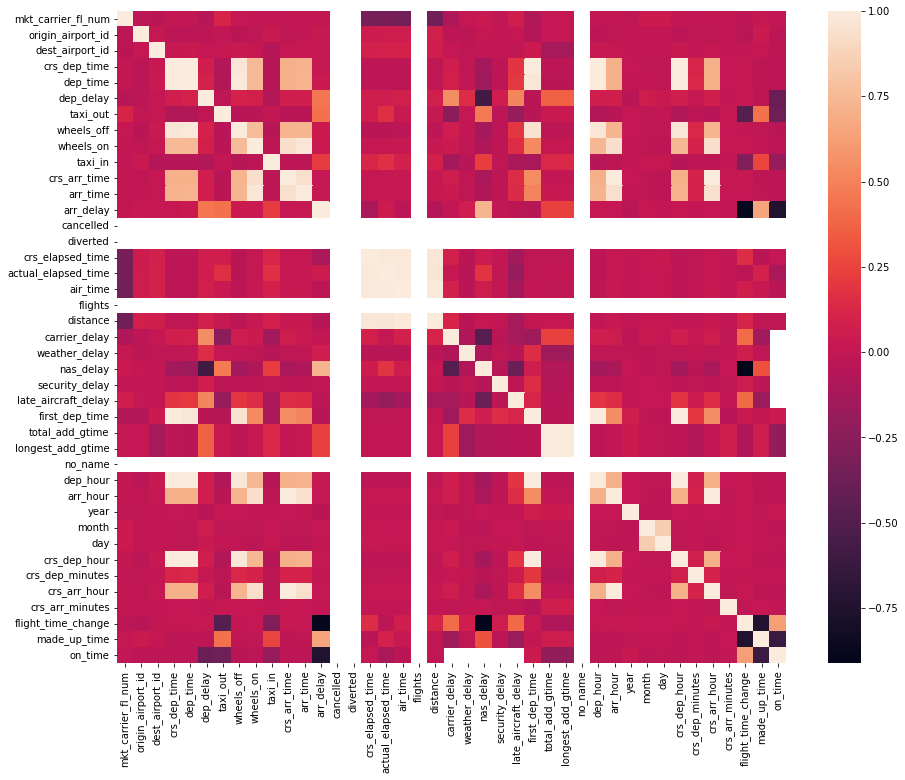

In [24]:
data_corr = data.corr()
fig, ax = plt.subplots(figsize=(15, 12))
sns.heatmap(data_corr, annot = False)



### Let's visualize flight delay frequency by day of week

In [25]:
# Lets see how the day of the week impacts delays

day_delays  = data[['week_day',
                  'arr_delay',]]

day_delays = day_delays.groupby('week_day').mean()
day_delays

,arr_delay
week_day,
Friday,-7.195174
Monday,-8.031786
Saturday,-8.612711
Sunday,-8.650759
Thursday,-7.686347
Tuesday,-9.316652
Wednesday,-8.716679


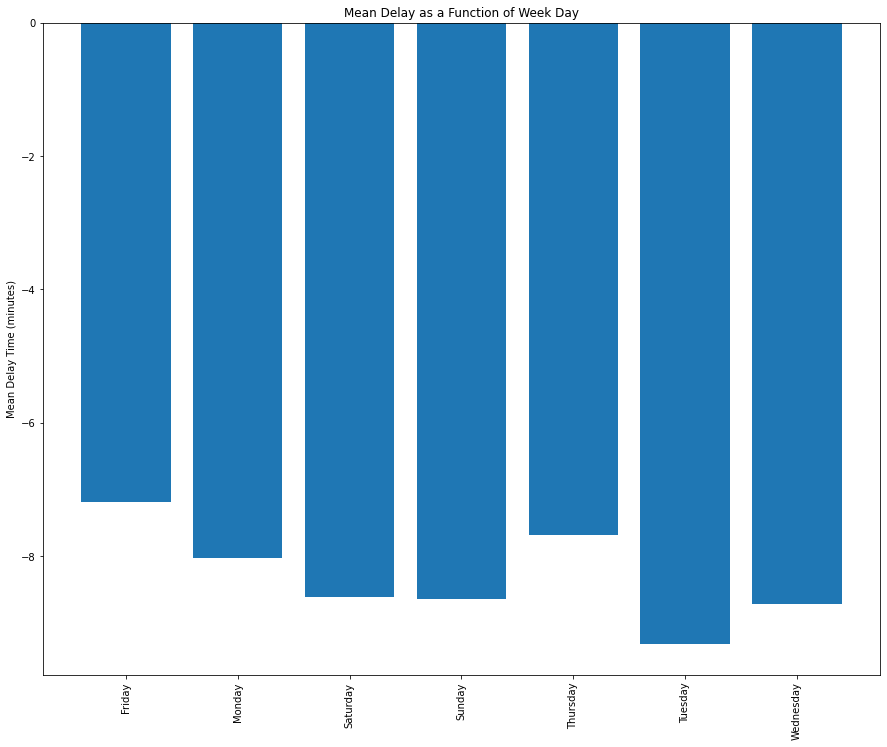

In [26]:
plt.subplots(figsize = (15,12))
plt.bar(x=day_delays.index, height = day_delays['arr_delay'])
plt.xticks(rotation = 90)
plt.title('Mean Delay as a Function of Week Day')
plt.ylabel('Mean Delay Time (minutes)')
plt.show()

#### **Task 1**: Test the hypothesis that the delay is from Normal distribution. and that **mean** of the delay is 0. Be careful about the outliers.

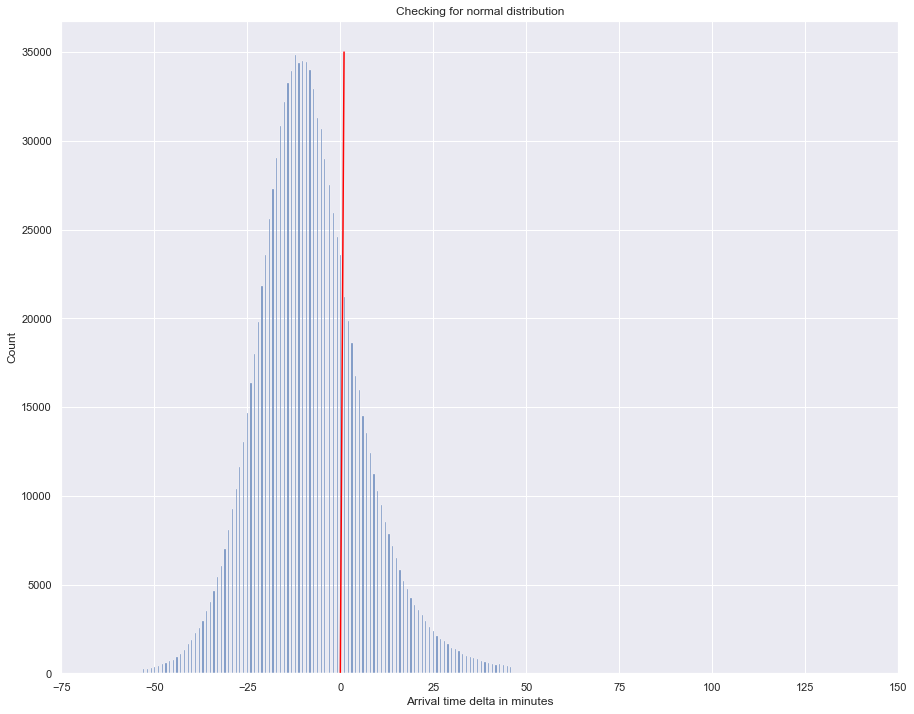

In [27]:
# Check the distribution of the data

sns.set(style = 'darkgrid')
fig, ax = plt.subplots(figsize=(15, 12))

h = sns.histplot(data, x = data['arr_delay'])
h.set(xlim = (-75, 150))
plt.plot([0, 35000], color='red')
plt.xlabel('Arrival time delta in minutes')
plt.title('Checking for normal distribution')
plt.show()

In [28]:
print('Mean flight arrival delta: ', data['arr_delay'].mean(), 'minutes')
print('Median flight arrival delta: ', data['arr_delay'].median(), 'minutes')

Mean flight arrival delta:  -8.344741175827323 minutes
Median flight arrival delta:  -9.0 minutes


#### **Task 2**: Is average/median monthly delay different during the year? If yes, which are months with the biggest delays and what could be the reason?

In [29]:
data[['month', 'arr_delay']].groupby('month').mean()

,arr_delay
month,
1,-8.568723
12,-8.156259


Delays definitely seem to be greater in December than in January, by about 1.2 minutes on average.  Not really concerned with the other months at this point for the purposes of our analysis.

#### **Task 3**: Does the weather affect the delay? 
Use the API to pull the weather information for flights. There is no need to get weather for ALL flights. We can choose the right representative sample. Let's focus on four weather types:
- sunny
- cloudy
- rainy
- snow.
Test the hypothesis that these 4 delays are from the same distribution. If they are not, which ones are significantly different?

In [30]:
# Let's see how weather severities are distributed
data['origin_weather_severity'].value_counts()

Light       994315
Moderate     47901
Severe       34603
Heavy         1005
Other         1002
UNK            227
Name: origin_weather_severity, dtype: int64

In [31]:
# Map severities of 'Heavy, other and UNK' to severe based on the high propensity for causing delays
data['origin_weather_severity'] = data['origin_weather_severity'].replace({'Heavy': 'Severe', 
                                                                          'Other': 'Severe',
                                                                          'UNK': 'Severe'},
                                                                         )
data['dest_weather_severity'] = data['dest_weather_severity'].replace({'Heavy': 'Severe', 
                                                                          'Other': 'Severe',
                                                                          'UNK': 'Severe'},
                                                                    )
data['origin_weather_severity'].value_counts()

Light       994315
Moderate     47901
Severe       36837
Name: origin_weather_severity, dtype: int64

In [32]:
# Simplify conditions to adverse or clear
data['origin_weather_condition'] = data['origin_weather_condition'].replace({'Rain': 'Adverse', 
                                                                          'Snow': 'Adverse',
                                                                          'Hail': 'Adverse',
                                                                           'Storm': 'Adverse',
                                                                            'Clear': 'Clear',
                                                                            'Fog': 'Adverse',
                                                                            'Cold': 'Adverse',
                                                                            'Precipitation': 'Adverse'},
                                                                         )

data['dest_weather_condition'] = data['dest_weather_condition'].replace({'Rain': 'Adverse', 
                                                                          'Snow': 'Adverse',
                                                                          'Hail': 'Adverse',
                                                                           'Storm': 'Adverse',
                                                                            'Clear': 'Clear',
                                                                            'Fog': 'Adverse',
                                                                            'Cold': 'Adverse',
                                                                            'Precipitation': 'Adverse'},
                                                                         )

In [33]:
origin_weather_chart = data[['origin_weather_condition', 'arr_delay']].groupby('origin_weather_condition').mean()
dest_weather_chart = data[['dest_weather_condition', 'arr_delay']].groupby('dest_weather_condition').mean()
origin_severity = data[['origin_weather_severity', 'arr_delay']].groupby('origin_weather_severity').mean()
dest_severity = data[['dest_weather_severity', 'arr_delay']].groupby('dest_weather_severity').mean()

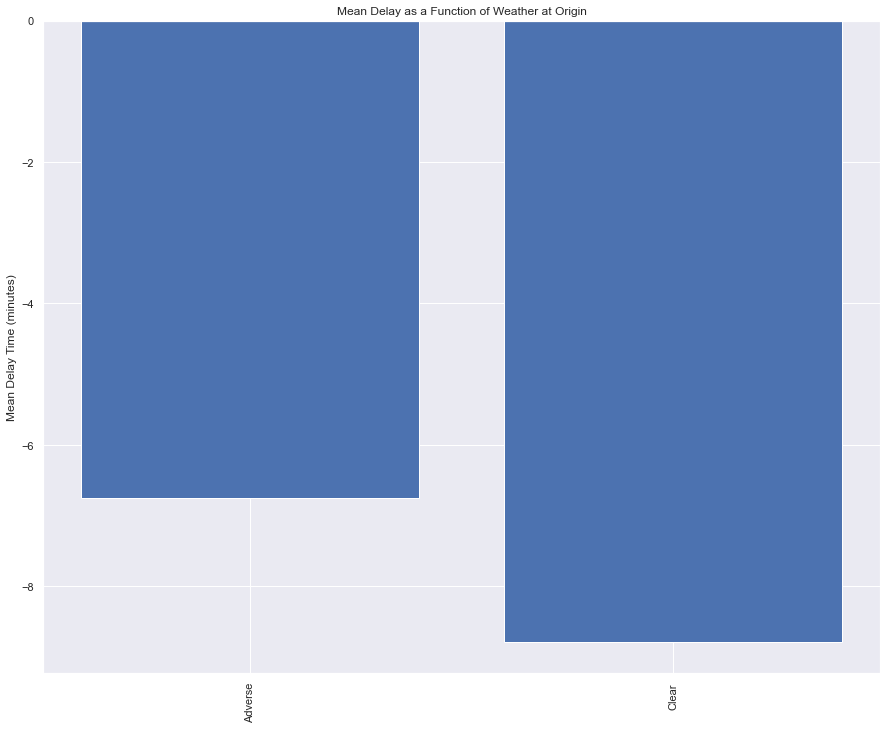

In [34]:
plt.subplots(figsize = (15,12))
plt.bar(x=origin_weather_chart.index, height = origin_weather_chart['arr_delay'])
plt.xticks(rotation = 90)
plt.title('Mean Delay as a Function of Weather at Origin')
plt.ylabel('Mean Delay Time (minutes)')
plt.show()

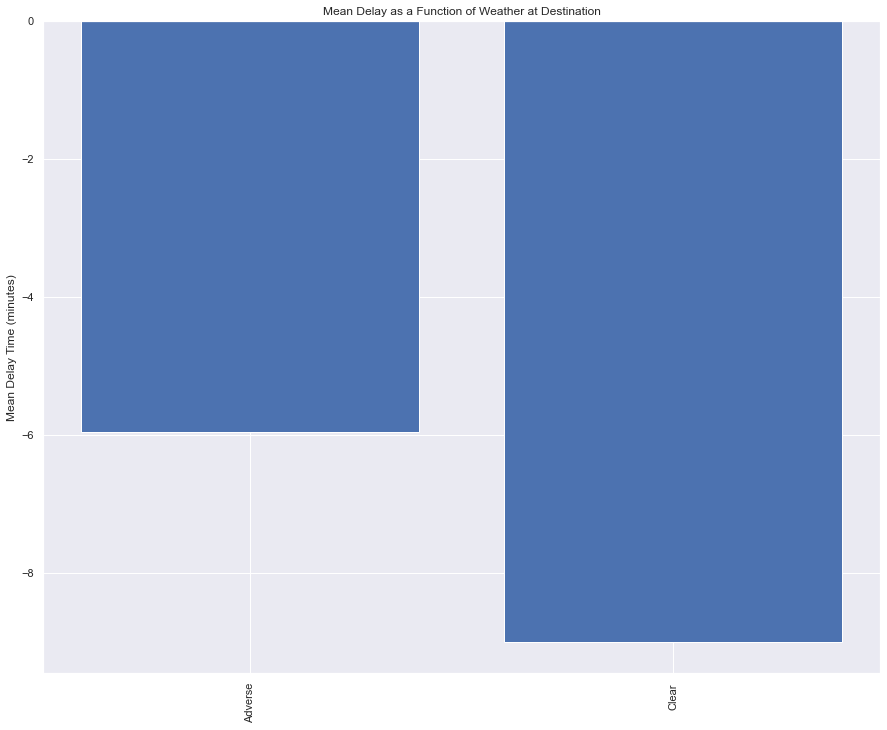

In [35]:
plt.subplots(figsize = (15,12))
plt.bar(x=dest_weather_chart.index, height = dest_weather_chart['arr_delay'])
plt.xticks(rotation = 90)
plt.title('Mean Delay as a Function of Weather at Destination')
plt.ylabel('Mean Delay Time (minutes)')
plt.show()

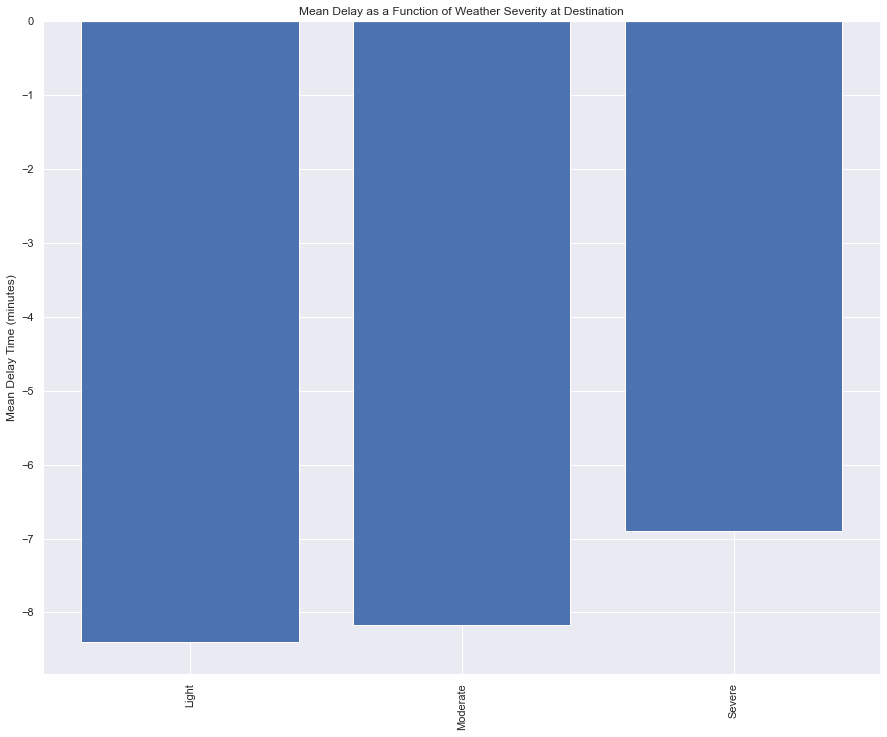

In [36]:
plt.subplots(figsize = (15,12))
plt.bar(x=origin_severity.index, height = origin_severity['arr_delay'])
plt.xticks(rotation = 90)
plt.title('Mean Delay as a Function of Weather Severity at Destination')
plt.ylabel('Mean Delay Time (minutes)')
plt.show()

#### **Task 4**: How taxi times changing during the day? Does higher traffic lead to bigger taxi times?

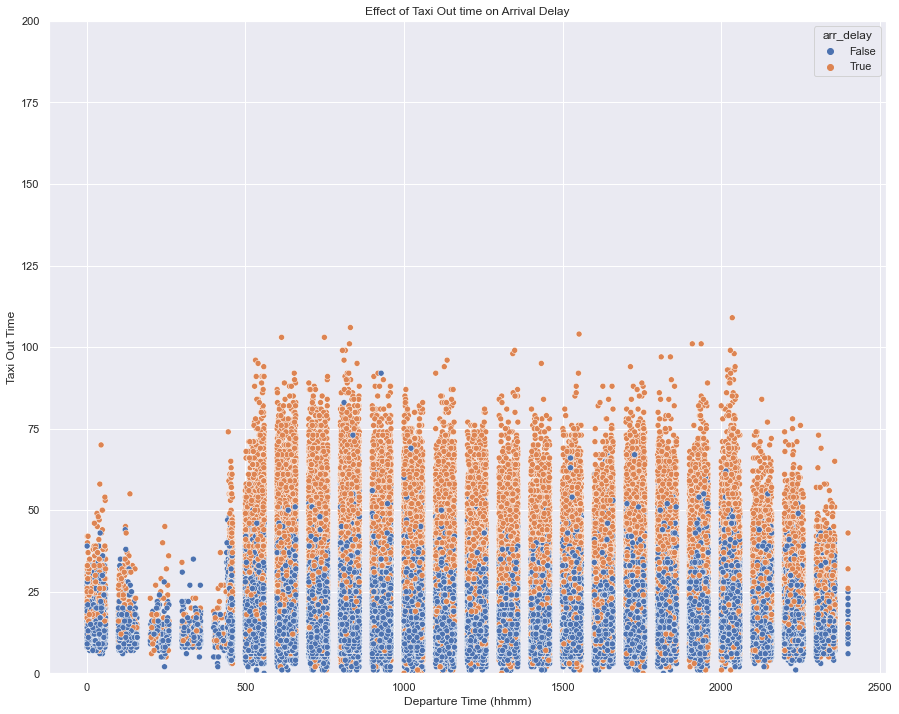

In [37]:
# Make a combined plot where the histogram shows the concentration of flights at a given time and a scatter plot (bubble) shows the duration of the taxi time.


fig, ax = plt.subplots(figsize=(15, 12))
# ax2 = ax.twinx()

# h = sns.histplot(data = data, x = data['dep_time'], ax = ax)
s = sns.scatterplot(data = data, x = data['dep_time'], y = data['taxi_out'], ax = ax, hue = (data['arr_delay'] > 0))


s.set(ylim = (0, 200))
plt.title('Effect of Taxi Out time on Arrival Delay')
plt.xlabel('Departure Time (hhmm)')
plt.ylabel('Taxi Out Time')

plt.show()

How are taxi out times distributed by airport?

In [38]:
# Are certain origin airports more likely to be associated with long taxi times?
taxi_port = data[['taxi_out', 'origin', 'arr_delay']].groupby(by = 'origin').mean()
taxi_port


,taxi_out,arr_delay
origin,,
ABE,16.283898,-9.307910
ABI,16.065292,-3.628866
ABQ,13.680211,-7.325066
ABR,21.872549,-8.921569
ABY,12.942029,-10.840580
...,...,...
XWA,26.466667,-11.666667
YAK,9.611111,-7.574074
YKM,6.828125,-1.046875


In [39]:
# Are certain destination airports more likely to be associated with long taxi times?
taxi_dest = data[['taxi_in', 'origin', 'arr_delay']].groupby(by = 'origin').mean()
taxi_dest

,taxi_in,arr_delay
origin,,
ABE,10.572034,-9.307910
ABI,10.120275,-3.628866
ABQ,8.290501,-7.325066
ABR,7.696078,-8.921569
ABY,7.731884,-10.840580
...,...,...
XWA,8.950000,-11.666667
YAK,3.888889,-7.574074
YKM,7.364583,-1.046875


In [40]:
x = taxi_port['taxi_out']
y = taxi_port['arr_delay']
m, b = np.polyfit(x, y, 1)

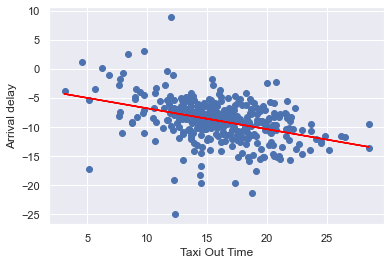

In [41]:
# Plotting average delay of arrival vs airport mean taxi time
plt.scatter(taxi_port['taxi_out'], taxi_port['arr_delay'])
plt.plot(x, m*x + b, color = 'red')
plt.xlabel('Taxi Out Time')
plt.ylabel('Arrival delay')
plt.show()

In [42]:
# Create a dicitonary of the mean taxi out time of each airport
mean_taxi_out = dict(zip(taxi_port.index, taxi_port['taxi_out']))
mean_taxi_in = dict(zip(taxi_dest.index, taxi_dest['taxi_in']))


#### **Task 5**: What is the average percentage of delays that is already created before departure? (aka are arrival delays caused by departure delays?) Are airlines able to lower the delay during the flights?

/Applications/anaconda3/envs/bootcamp_env/lib/python3.6/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


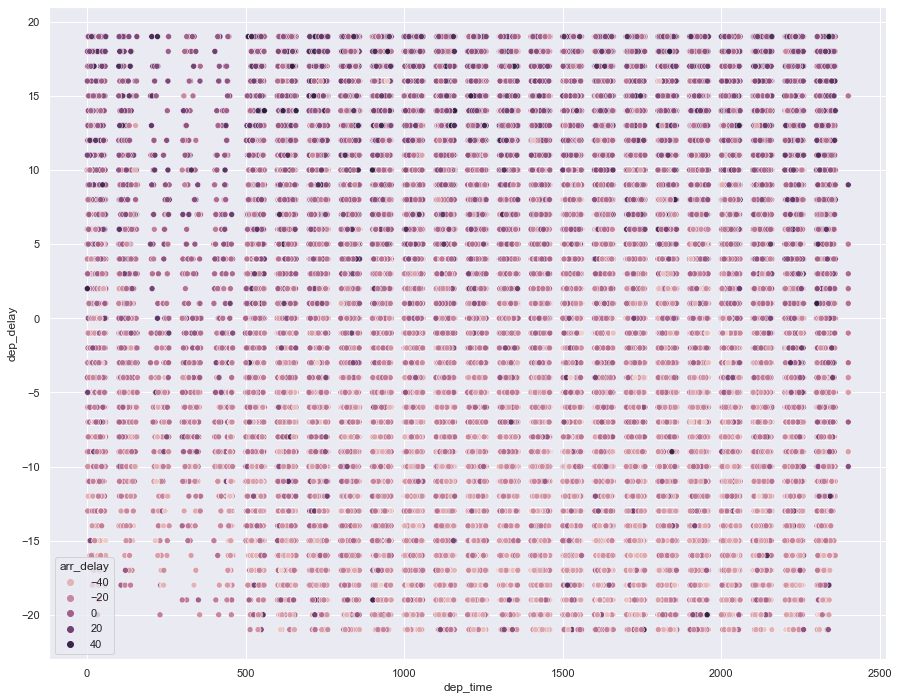

In [43]:
fig, ax = plt.subplots(figsize=(15, 12))

s = sns.scatterplot(data = data, 
                    x = data['dep_time'],
                    y = data['dep_delay'], 
                    ax = ax, 
                    hue = (data['arr_delay']))

#### **Task 6**: How many states cover 50% of US air traffic? 

In [44]:
counts = data['dep_state'].value_counts() + data['dest_state'].value_counts()
counts = counts.sort_values(ascending = False)

In [45]:
big_state_count = 0
high_traffic_states = []
i = 0
while big_state_count <= counts.sum()/2:
    big_state_count += counts[i]
    high_traffic_states.append(counts.index[i])
    i += 1
print("50% of American air traffic occurs in these states: \n", high_traffic_states)

50% of American air traffic occurs in these states: 
 [' CA', ' TX', ' FL', ' IL', ' GA', ' NY', ' NC', ' CO']


<BarContainer object of 10 artists>

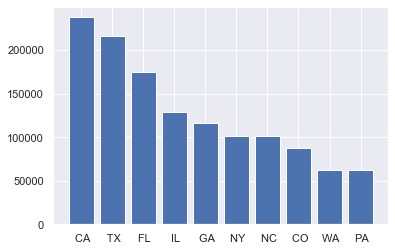

In [46]:
plt.bar(x = counts.index[:10], height = counts[:10])

#### **Task 7**: Test the hypothesis whether planes fly faster when there is the departure delay? 

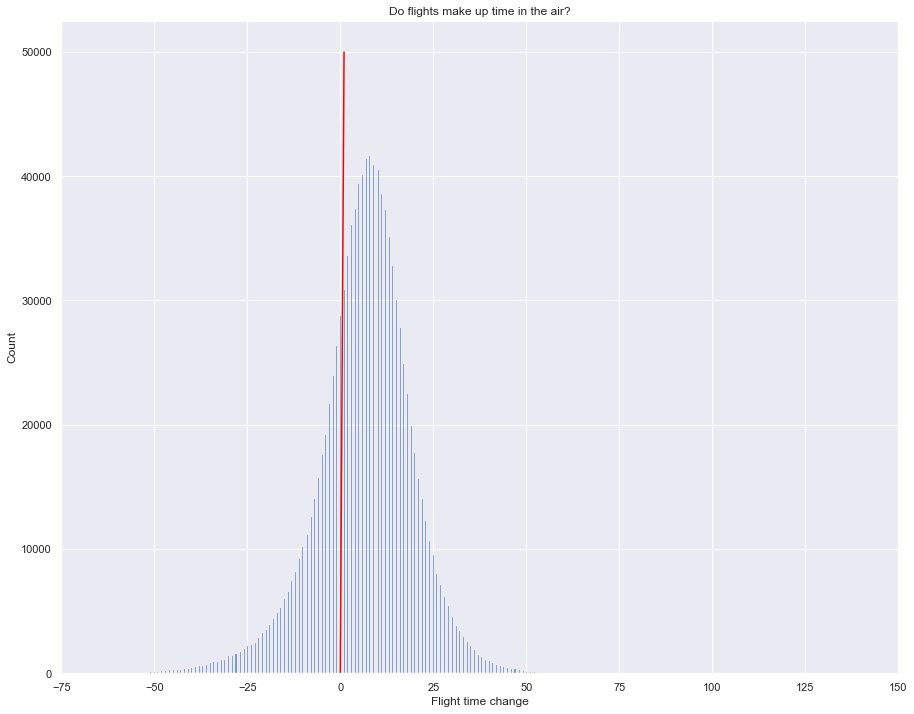

In [47]:
# Make a histogram showing the flight time change for all flights

sns.set(style = 'darkgrid')
fig, ax = plt.subplots(figsize=(15, 12))

h = sns.histplot(data, x = data['flight_time_change'])
h.set(xlim = (-75, 150))
plt.plot([0, 50000], color='red')
plt.xlabel('Flight time change')
plt.title('Do flights make up time in the air?')
plt.show()
# plt.scatter(data['dep_delay'], data['flight_time_change'])

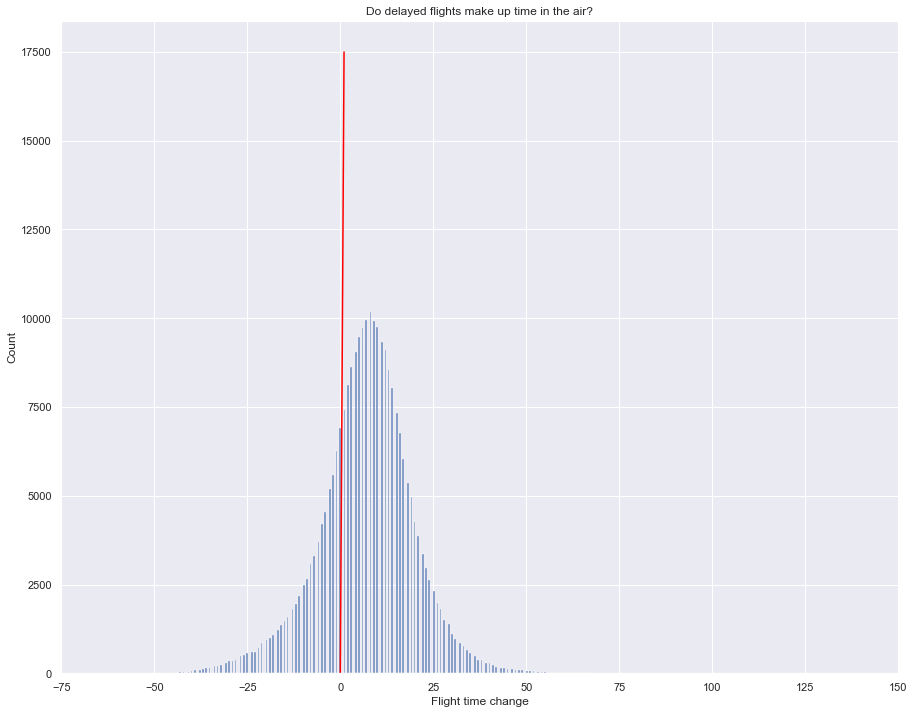

In [48]:
# Create the same histogram, but this time only use the flights that departed late

dep_delay = data[data['dep_delay'] > 0]

fig, ax = plt.subplots(figsize=(15, 12))
h = sns.histplot(dep_delay, x = dep_delay['flight_time_change'])
h.set(xlim = (-75, 150))
plt.plot([0, 17500], color='red')
plt.xlabel('Flight time change')
plt.title('Do delayed flights make up time in the air?')
plt.show()


#### **Task 8**: When (which hour) do most 'LONG', 'SHORT', 'MEDIUM' haul flights take off?

In [49]:
arrays = [data['crs_dep_hour'], data['haul_type']]
hauls = data['haul_type'].to_list()
index = pd.MultiIndex.from_arrays(arrays, names=('Departure Hour', 'Haul Type'))

df = pd.DataFrame(hauls, index=index)
df = df.groupby(by =['Departure Hour', 'Haul Type']).count()

In [50]:
df = df.reset_index()

Text(0.5, 1.0, 'Departure types by hour of day')

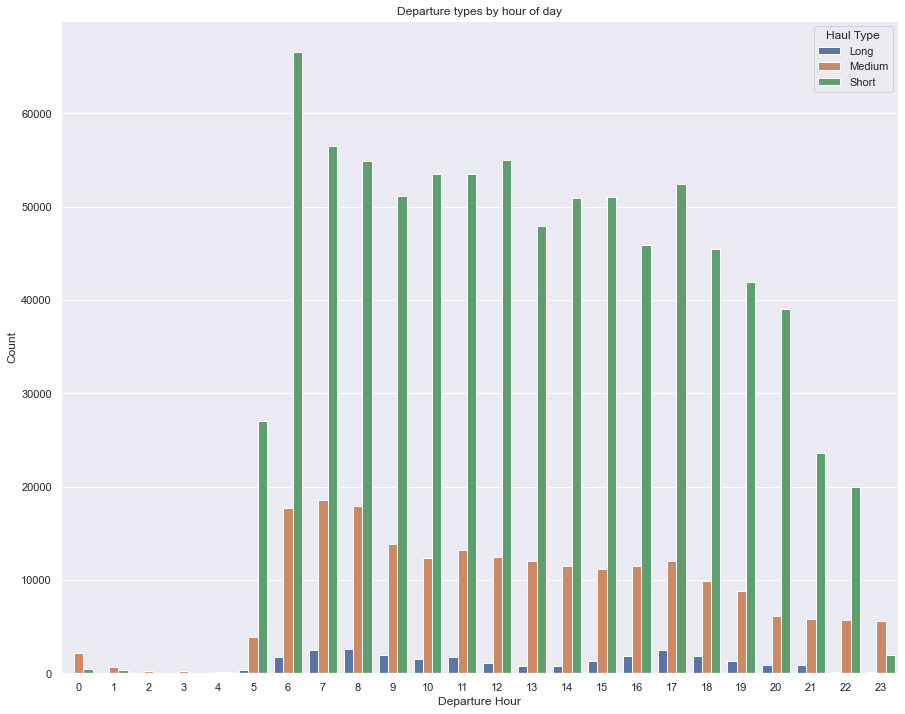

In [51]:
# Plot a bar plot of distance (mean) as a function of dep_time 
fig, ax = plt.subplots(figsize=(15, 12))
sns.barplot(data = df, x = 'Departure Hour', y = 0, hue = 'Haul Type')
plt.ylabel('Count')
plt.title('Departure types by hour of day')

In [52]:
del_by_hr = data[['crs_dep_hour', 'arr_delay']]
del_by_hr = del_by_hr.groupby('crs_dep_hour').mean()

Text(0.5, 1.0, 'Arrival delta by hour of day')

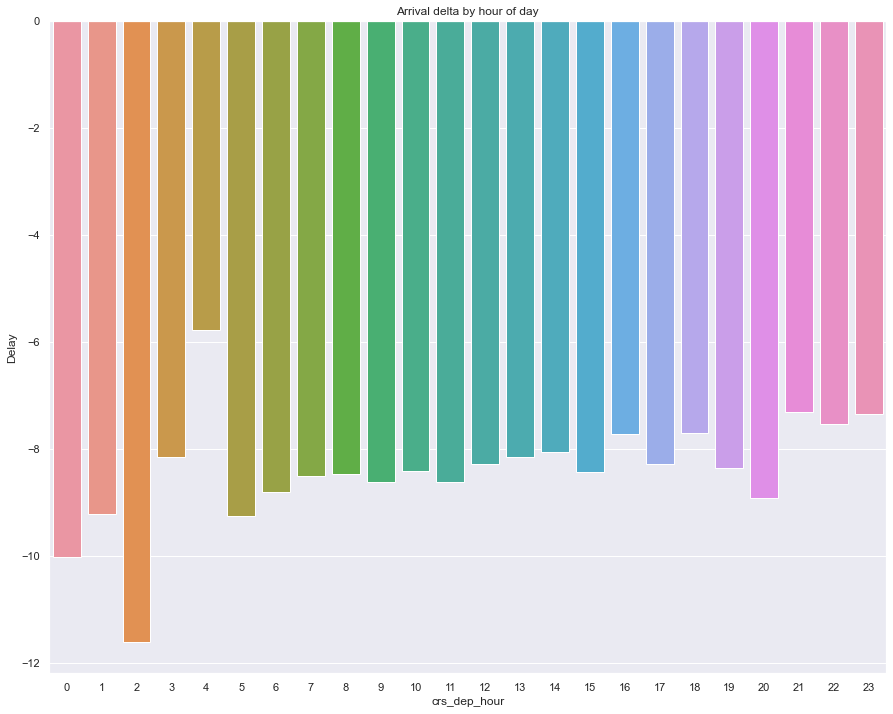

In [53]:
fig, ax = plt.subplots(figsize=(15, 12))
sns.barplot(data = del_by_hr, x = del_by_hr.index, y = 'arr_delay')
plt.ylabel('Delay')
plt.title('Arrival delta by hour of day')

#### **Task 9**: Find the top 10 the bussiest airports. Does the biggest number of flights mean that the biggest number of passengers went through the particular airport? How much traffic do these 10 airports cover?

Going to compare number of flights per airport vs the number of passengers per airport.  Found that number of flights is correlated with number of passengers, however it is not perfect.  Some of the airports ranked below number 5 in terms of total flights are not even in the top 10 when it comes to passenger count.  

The top 10 airports represent 32.4% of passenger traffic

In [54]:
# Create a list of the most heavily trafficked airports by number of flights

airport_counts = data['origin'].value_counts() + data['dest'].value_counts()
flight_counts = airport_counts.sort_values(ascending = False).head(10).index.to_list()

In [55]:
passengers = pd.read_csv('data/passengers.csv')
passengers = passengers[(passengers['origin_country_name'] == 'United States') & (passengers['dest_country_name'] == 'United States')]

passengers.head(10)

,Unnamed: 0,departures_scheduled,departures_performed,payload,seats,passengers,freight,mail,distance,ramp_to_ramp,...,dest_country,dest_country_name,aircraft_group,aircraft_type,aircraft_config,year,month,distance_group,class,data_source
4,4,0.0,1.0,31200.0,156.0,96.0,0.0,0.0,707.0,126.0,...,US,United States,6,698,1,2019,1,2,L,DU
5,5,0.0,1.0,37200.0,186.0,144.0,0.0,0.0,2211.0,252.0,...,US,United States,6,694,1,2019,1,5,L,DU
6,6,0.0,1.0,31200.0,156.0,84.0,0.0,0.0,368.0,90.0,...,US,United States,6,698,1,2019,1,1,L,DU
7,7,0.0,2.0,62400.0,312.0,76.0,0.0,0.0,1217.0,450.0,...,US,United States,6,698,1,2019,1,3,L,DU
8,8,0.0,1.0,31200.0,156.0,156.0,0.0,0.0,1465.0,252.0,...,US,United States,6,698,1,2019,1,3,L,DU
9,9,0.0,1.0,22750.0,76.0,0.0,0.0,0.0,424.0,310.0,...,US,United States,6,638,1,2019,1,1,F,DU
10,10,0.0,1.0,22750.0,76.0,64.0,0.0,0.0,958.0,127.0,...,US,United States,6,638,1,2019,1,2,F,DU
11,11,0.0,3.0,68250.0,228.0,111.0,0.0,0.0,113.0,194.0,...,US,United States,6,638,1,2019,1,1,F,DU
12,12,0.0,1.0,18800.0,70.0,0.0,0.0,0.0,298.0,121.0,...,US,United States,6,631,1,2019,1,1,F,DU
13,13,0.0,1.0,18800.0,70.0,1.0,0.0,0.0,95.0,85.0,...,US,United States,6,631,1,2019,1,1,F,DU


In [56]:
passengers.columns

Index(['Unnamed: 0', 'departures_scheduled', 'departures_performed', 'payload',
       'seats', 'passengers', 'freight', 'mail', 'distance', 'ramp_to_ramp',
       'air_time', 'unique_carrier', 'airline_id', 'unique_carrier_name',
       'region', 'carrier', 'carrier_name', 'carrier_group',
       'carrier_group_new', 'origin_airport_id', 'origin_city_market_id',
       'origin', 'origin_city_name', 'origin_country', 'origin_country_name',
       'dest_airport_id', 'dest_city_market_id', 'dest', 'dest_city_name',
       'dest_country', 'dest_country_name', 'aircraft_group', 'aircraft_type',
       'aircraft_config', 'year', 'month', 'distance_group', 'class',
       'data_source'],
      dtype='object')

In [57]:
pass_dest = passengers[['dest', 'passengers']]
pass_origin = passengers[['origin', 'passengers']]

In [58]:
# Create lists of the most heavily trafficked airports by passengers

dest_traffic = pass_dest.groupby('dest').sum().sort_values(by = 'passengers', ascending = False).head(10)
origin_traffic = pass_origin.groupby('origin').sum().sort_values(by='passengers', ascending = False).head(10)


In [59]:
# Get the sums of the 10 highest trafficed airports
sum_dest_traffic = dest_traffic.head(10).sum()
sum_origin_traffic = origin_traffic.head(10).sum()
print('Destination Traffic: ', sum_dest_traffic)
print('Origin Traffic: ', sum_origin_traffic)

Destination Traffic:  passengers    209673954.0
dtype: float64
Origin Traffic:  passengers    208721707.0
dtype: float64


In [60]:
# Convert to lists
dest_traffic_list = dest_traffic.head(10).index.to_list()
origin_traffic_list = origin_traffic.head(10).index.to_list()

In [61]:
print(flight_counts)
print(dest_traffic_list)
print(origin_traffic_list)

['ATL', 'ORD', 'DFW', 'DEN', 'LAX', 'CLT', 'SEA', 'PHX', 'IAH', 'DTW']
['ATL', 'ORD', 'LAX', 'DFW', 'DEN', 'PHX', 'LAS', 'CLT', 'MCO', 'SFO']
['ATL', 'ORD', 'LAX', 'DFW', 'DEN', 'PHX', 'LAS', 'CLT', 'MCO', 'SFO']


In [62]:
print('Top 10 airports as a percentage of total destination traffic:' , sum_dest_traffic / passengers['passengers'].sum())
print('Top 10 airports as a percentage of total origin traffic:' , sum_origin_traffic / passengers['passengers'].sum())

Top 10 airports as a percentage of total destination traffic: passengers    0.355362
dtype: float64
Top 10 airports as a percentage of total origin traffic: passengers    0.353748
dtype: float64


# Delay as a function of distance

In [63]:
m, n = np.polyfit(data['distance'], data['arr_delay'], 1)

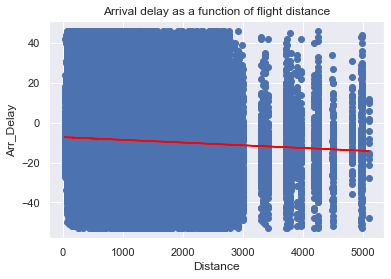

In [64]:
plt.scatter(data['distance'], data['arr_delay'])
plt.plot(data['distance'], m*data['distance'] + n, color = 'red')
plt.xlabel('Distance')
plt.ylabel('Arr_Delay')
plt.title('Arrival delay as a function of flight distance')
plt.show()

# Delay as a function of elapsed time

In [65]:
m, b = np.polyfit(data['crs_elapsed_time'], data['arr_delay'], 1)

In [66]:
# plt.scatter(data['crs_elapsed_time'], data['arr_delay'])
# plt.plot(data['crs_elapsed_time'], m*data['distance'] + b, color = 'red')
# plt.xlabel('crs_elapsed_time')
# plt.ylabel('Arr_Delay')
# plt.title('Arrival delay as a function of flight distance')
# plt.show()

# **Task 10**: Do bigger delays lead to bigger fuel comsumption per passenger? 
We need to do four things to answer this as accurate as possible:
- Find out average monthly delay per air carrier (monthly delay is sum of all delays in 1 month)
- Find out distance covered monthly by different air carriers
- Find out number of passengers that were carried by different air carriers
- Find out total fuel comsumption per air carrier.

Use this information to get the average fuel comsumption per passenger per km. Is this higher for the airlines with bigger average delays?

In [67]:
# Get the average monthly delay by carrier
q10_carrier= data[['mkt_unique_carrier', 'arr_delay']].groupby(by = ['mkt_unique_carrier']).mean().rename(columns={'arr_delay':'mean_delay'})


In [68]:
# Get the carrier distance 
q10_cardist = data[['mkt_unique_carrier', 'distance']].groupby(by=['mkt_unique_carrier']).sum().rename(columns = {'arr_delay': 'total_distance'})


In [69]:
carrier_list = ['AA','AS','B6','DL','F9','G4','HA','NK','UA','VX','WN']

In [70]:
# Monthly passenger count by carrier
q10_pass = passengers[['carrier', 'month', 'year','passengers']]
q10_pass = q10_pass[(q10_pass['month'] == 1) | (q10_pass['month'] == 12)]
q10_pass = q10_pass[(q10_pass['year'] == 2018) | (q10_pass['year'] == 2019)]
q10_pass = q10_pass[q10_pass['carrier'].isin(carrier_list)].drop(columns='year')
q10_pass = q10_pass[['carrier', 'passengers']].groupby(by=['carrier']).sum().rename(columns = {'passengers': 'total_monthly_passengers'})


In [71]:
# Load the fuel dataset
fuel = pd.read_csv('data/fuel.csv')

In [72]:
# Filter the fuel dataset so that the dates correspond to jan, dec of 2018, 2019



fuel = fuel[(fuel['month'] == 1) | (fuel['month'] == 12)]
fuel = fuel[(fuel['year'] == 2018) | (fuel['year'] == 2019)]
fuel = fuel[[ 'carrier', 'tdomt_gallons']]
fuel = fuel[fuel['carrier'].isin(carrier_list)].groupby(by=['carrier']).sum()

# # Add VX based on mean of other carriers 



In [73]:
q10 = pd.concat([fuel, q10_pass, q10_cardist, q10_carrier], axis = 1)

q10['fuel_consumption'] = q10.tdomt_gallons / q10.distance
q10['fuel_per_passenger'] = q10.fuel_consumption / q10.total_monthly_passengers

# Add VX based on mean of other carriers 
calc = q10['fuel_per_passenger'].mean()
q10['fuel_per_passenger'].fillna(value=calc, inplace=True)

In [74]:

q10

,tdomt_gallons,total_monthly_passengers,distance,mean_delay,fuel_consumption,fuel_per_passenger
AA,540402607.0,39402793.0,202932142.0,-6.956930,2.662972,6.758333e-08
AS,170743617.0,9786156.0,57715064.0,-6.906451,2.958389,3.023035e-07
B6,167571226.0,10769636.0,41054083.0,-9.157940,4.081719,3.790025e-07
DL,496871060.0,39305600.0,168226948.0,-11.928509,2.953576,7.514390e-08
F9,59119295.0,6609871.0,17353067.0,-10.723676,3.406850,5.154185e-07
G4,41327782.0,4277466.0,12465908.0,-5.364533,3.315264,7.750534e-07
HA,46363424.0,3410128.0,9042561.0,-2.143562,5.127245,1.503534e-06
NK,91722197.0,9087123.0,28202892.0,-8.768192,3.252227,3.578940e-07
UA,393411829.0,26384508.0,169921378.0,-8.533660,2.315258,8.775066e-08
WN,497872706.0,51563654.0,134924408.0,-6.382972,3.690012,7.156227e-08


Text(0.5, 1.0, 'Carrier Fuel Consumption')

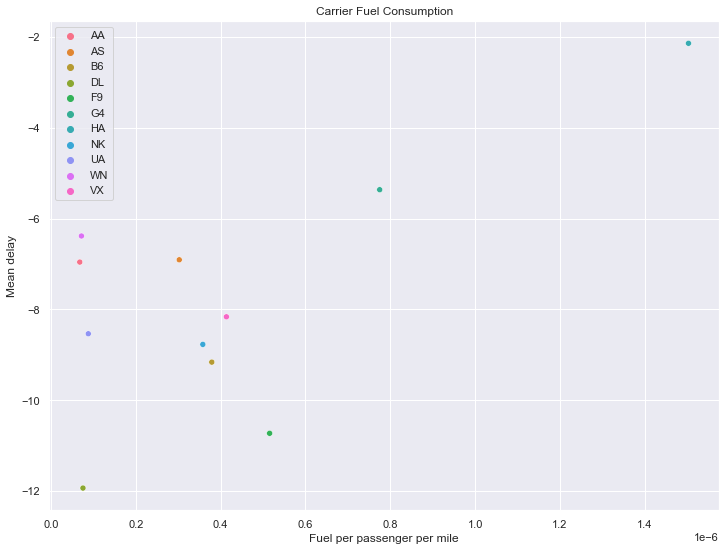

In [75]:
fig, ax = plt.subplots(figsize=(12, 9))

sns.scatterplot(data = q10, x = q10['fuel_per_passenger'],y = q10['mean_delay'], hue = q10.index)

plt.xlabel('Fuel per passenger per mile')
plt.ylabel('Mean delay')
plt.title('Carrier Fuel Consumption')

In [76]:
fuel_dict = dict(zip(q10.index, q10.fuel_per_passenger))
fuel_dict

{'AA': 6.758333032722901e-08,
 'AS': 3.0230349006383993e-07,
 'B6': 3.790024925393323e-07,
 'DL': 7.514389562564466e-08,
 'F9': 5.154185194490982e-07,
 'G4': 7.750533796718525e-07,
 'HA': 1.503534417132214e-06,
 'NK': 3.57893983726472e-07,
 'UA': 8.775066017441495e-08,
 'WN': 7.15622705580902e-08,
 'VX': 4.1352464392681876e-07}

# Checking out carrier stats

In [77]:
# Calculate the mean delay by carrier
mean_carrier_delays = data[['mkt_unique_carrier','arr_delay']].groupby('mkt_unique_carrier').mean().rename(columns = {'arr_delay': 'mean_delay'})
median_carrier_delays = data[['mkt_unique_carrier','arr_delay']].groupby('mkt_unique_carrier').median().rename(columns = {'arr_delay': 'median_delay'})
carrier_flight_count = data[['mkt_unique_carrier','arr_delay']].groupby('mkt_unique_carrier').count().rename(columns = {'arr_delay': 'flight_count'})
c_delays = data[['mkt_unique_carrier','on_time']].groupby('mkt_unique_carrier').sum().rename(columns = {'arr_delay': 'on_time'})

# Merge the various value count tables created
carrier_delays = mean_carrier_delays.merge(median_carrier_delays,left_index = True, right_index = True)
carrier_delays = carrier_delays.merge(carrier_flight_count, left_index = True, right_index = True)
carrier_delays = carrier_delays.merge(c_delays, left_index = True, right_index = True)

# Calculate on time % as a function of the elements in the table
carrier_delays['on_time_pct'] = carrier_delays['on_time']/carrier_delays['flight_count']

In [78]:
carrier_delays.sort_values(by='on_time_pct')

,mean_delay,median_delay,flight_count,on_time,on_time_pct
mkt_unique_carrier,,,,,
HA,-2.143562,-3.0,14391,9546,0.663331
G4,-5.364533,-6.0,13686,9591,0.700789
AS,-6.906451,-8.0,59017,42083,0.713066
VX,-8.160722,-9.0,2271,1673,0.736680
AA,-6.956930,-8.0,283611,209343,0.738134
WN,-6.382972,-7.0,181358,135438,0.746799
B6,-9.157940,-10.0,36843,27981,0.759466
UA,-8.533660,-10.0,208007,159518,0.766888
NK,-8.768192,-10.0,27704,21684,0.782703


In [79]:
# Create a dictionary with the relevant on time percentage (values) and airlines(keys)
carrier_pct = dict(zip(carrier_delays.index, carrier_delays['on_time_pct']))
carrier_pct

{'AA': 0.738134275468864,
 'AS': 0.7130657268244743,
 'B6': 0.7594658415438482,
 'DL': 0.8308451798304631,
 'F9': 0.7862139669521168,
 'G4': 0.7007891275756247,
 'HA': 0.6633312486971024,
 'NK': 0.7827028587929541,
 'UA': 0.7668876528193763,
 'VX': 0.7366798767062968,
 'WN': 0.746799148645221}

In [80]:
# Create a dictionary of airlines and their carrier codes
airlines = {'AA': 'American Airlines',
           'AS': 'Alaska Airlines',
           'B6': 'JetBlue',
           'DL': 'Delta',
           'F9': 'Frontier',
           'G4': 'Allegiant',
           'HA': 'Hawaiian Airlines',
           'NK': 'Spirit Airlines',
           'UA': 'United Airlines',
           'VX': 'Virgin America',
           'WN': 'Southwest Airlines'}

# Checking out individual Plane Delays

In [81]:
# Create a summary dataframe of how bad each plane is in terms of delays

# Summary columns
mean_plane_delays = data[['tail_num','arr_delay']].groupby('tail_num').mean().rename(columns = {'arr_delay': 'mean_delay'})
median_plane_delays = data[['tail_num','arr_delay']].groupby('tail_num').median().rename(columns = {'arr_delay': 'median_delay'})
plane_counts = data[['tail_num','arr_delay']].groupby('tail_num').count().rename(columns = {'arr_delay': 'flight_count'})
delays = data[['tail_num', 'on_time']].groupby('tail_num').sum().rename(columns = {'arr_delay': 'on_time'})

# Merging of columns
plane_mex = mean_plane_delays.merge(median_plane_delays, left_index = True, right_index = True)
plane_mex = plane_mex.merge(plane_counts, left_index = True, right_index = True)
plane_mex = plane_mex.merge(delays, left_index = True, right_index  = True)
plane_mex = plane_mex.dropna(axis = 0)
plane_mex['on_time_pct'] = plane_mex['on_time'] / plane_mex['flight_count']

In [82]:
plane_mex.sort_values(by='on_time_pct', ascending = True).head(5)

,mean_delay,median_delay,flight_count,on_time,on_time_pct
tail_num,,,,,
N26952,13.500000,13.5,2,0,0.0
N24974,16.666667,16.0,3,0,0.0
N2243U,1.500000,1.5,2,0,0.0
N719AN,2.000000,2.0,1,0,0.0
N375PH,6.000000,6.0,1,0,0.0


In [83]:
# Create a dictionary of tail numbers (keys) and on_time_pct (values)
plane_pct = dict(zip(plane_mex.index, plane_mex['on_time_pct']))

# Checking out airport delays 

In [84]:
# Create a summary dataframe of how bad each airport is for delays

# Summary columns
mean_ap_delays = data[['origin','arr_delay']].groupby('origin').mean().rename(columns = {'arr_delay': 'mean_delay'})
median_ap_delays = data[['origin','arr_delay']].groupby('origin').median().rename(columns = {'arr_delay': 'median_delay'})
ap_counts = data[['origin','arr_delay']].groupby('origin').count().rename(columns = {'arr_delay': 'flight_count'})
delays = data[['origin', 'on_time']].groupby('origin').sum().rename(columns = {'arr_delay': 'on_time'})

# Merging of columns
ap_delay = mean_ap_delays.merge(median_ap_delays, left_index = True, right_index = True)
ap_delay = ap_delay.merge(ap_counts, left_index = True, right_index = True)
ap_delay = ap_delay.merge(delays, left_index = True, right_index  = True)
ap_delay['on_time_pct'] = ap_delay['on_time'] / ap_delay['flight_count']

In [85]:
ap_delay[ap_delay['flight_count'] > 1000].sort_values(by='on_time_pct')

,mean_delay,median_delay,flight_count,on_time,on_time_pct
origin,,,,,
OGG,-3.278027,-4.0,4237,2735,0.645504
RDM,-4.825137,-4.0,1098,725,0.660291
HNL,-2.664853,-3.0,8823,5904,0.669160
SGF,-5.424153,-7.0,1358,920,0.677467
MFR,-5.291775,-6.0,1155,786,0.680519
...,...,...,...,...,...
MHT,-11.835549,-13.0,1429,1177,0.823653
RSW,-10.427549,-12.0,6570,5415,0.824201
PIE,-10.511265,-11.0,1154,966,0.837088


In [86]:
# Create a dict to store the on time percentages of the various origin airports
origin_pct = dict(zip(ap_delay.index, ap_delay['on_time_pct']))

# Flight number delays

In [87]:
# Create a summary dataframe of how bad each flight is for delays

# Summary columns
mean_flight_delays = data[['mkt_carrier_fl_num','arr_delay']].groupby('mkt_carrier_fl_num').mean().rename(columns = {'arr_delay': 'mean_delay'})
median_flight_delays = data[['mkt_carrier_fl_num','arr_delay']].groupby('mkt_carrier_fl_num').median().rename(columns = {'arr_delay': 'median_delay'})
flight_counts = data[['mkt_carrier_fl_num','arr_delay']].groupby('mkt_carrier_fl_num').count().rename(columns = {'arr_delay': 'flight_count'})
flight_delays = data[['mkt_carrier_fl_num', 'on_time']].groupby('mkt_carrier_fl_num').sum().rename(columns = {'arr_delay': 'on_time'})

# Merging of columns
fl_delay = mean_flight_delays.merge(median_flight_delays, left_index = True, right_index = True)
fl_delay = fl_delay.merge(flight_counts, left_index = True, right_index = True)
fl_delay = fl_delay.merge(flight_delays, left_index = True, right_index  = True)
fl_delay['on_time_pct'] = fl_delay['on_time'] / fl_delay['flight_count']

In [88]:
fl_delay.sort_values(by='on_time_pct')

,mean_delay,median_delay,flight_count,on_time,on_time_pct
mkt_carrier_fl_num,,,,,
6947,16.000000,16.0,2,0,0.0
6963,19.000000,19.0,2,0,0.0
9343,32.000000,32.0,1,0,0.0
9380,4.000000,4.0,1,0,0.0
9340,1.000000,1.0,1,0,0.0
...,...,...,...,...,...
6440,-14.000000,-18.0,3,3,1.0
7362,-20.594595,-21.0,37,37,1.0
6870,-12.750000,-13.0,4,4,1.0


In [89]:
# Create a dict to store the on-time percentages of various flights
fl_num_pct = dict(zip(fl_delay.index, fl_delay['on_time_pct']))

# Does Route as a feature improve upon the previous metrics?

In [90]:
# Summary columns
mean_route_delays = data[['route','arr_delay']].groupby('route').mean().rename(columns = {'arr_delay': 'mean_delay'})
median_route_delays = data[['route','arr_delay']].groupby('route').median().rename(columns = {'arr_delay': 'median_delay'})
route_counts = data[['route','arr_delay']].groupby('route').count().rename(columns = {'arr_delay': 'flight_count'})
route_delays = data[['route', 'on_time']].groupby('route').sum().rename(columns = {'arr_delay': 'on_time'})

# Merging of columns
r_delay = mean_route_delays.merge(median_route_delays, left_index = True, right_index = True)
r_delay = r_delay.merge(route_counts, left_index = True, right_index = True)
r_delay = r_delay.merge(route_delays, left_index = True, right_index  = True)
r_delay['on_time_pct'] = r_delay['on_time'] / r_delay['flight_count']

In [91]:
r_delay.sort_values(by='on_time_pct')

,mean_delay,median_delay,flight_count,on_time,on_time_pct
route,,,,,
PBI_CVG,12.000000,12.0,1,0,0.0
DAL_PNS,5.000000,5.0,2,0,0.0
MDT_SRQ,19.000000,19.0,2,0,0.0
SFB_YNG,15.000000,15.0,1,0,0.0
CLE_SFB,13.333333,11.0,3,0,0.0
...,...,...,...,...,...
JAC_LGA,-35.000000,-35.0,1,1,1.0
PIE_TVC,-16.400000,-18.0,5,5,1.0
PHL_EGE,-35.500000,-35.5,2,2,1.0


In [92]:
route_pct = dict(zip(r_delay.index, r_delay['on_time_pct']))

# Dropping Remaining Columns

The following columns will be dropped for the final dataframe for two reasons. <br>
Either the information is duplicated in some way, elsewhere in the table.  Or the information relates to flights in progress or that have 
already happened, therefore, they cannot be used to predict future flights.

In [93]:
data = data.drop(columns = ['branded_code_share',
                           'mkt_carrier',
                           'origin_airport_id',
                            'origin_city_name',
                            'dest_city_name',
                           'dest_airport_id',
                           'wheels_off',
                           'wheels_on',
                           'taxi_in',
                           'taxi_out',
                           'diverted',
                           'longest_add_gtime',
                           'total_add_gtime',
                           'crs_elapsed_time',
                           'actual_elapsed_time',
                           'air_time',
                           'flight_time_change',
                           'made_up_time', 
                           'no_name',
                           'arr_time',
                           'flights',
                           'dep_time',
                           'dep_delay',
                            'dep_hour',
                            'arr_hour',
                            'first_dep_time',])

In [94]:
data.columns

Index(['mkt_unique_carrier', 'mkt_carrier_fl_num', 'tail_num', 'origin',
       'dest', 'crs_dep_time', 'crs_arr_time', 'arr_delay', 'cancelled',
       'cancellation_code', 'distance', 'carrier_delay', 'weather_delay',
       'nas_delay', 'security_delay', 'late_aircraft_delay', 'dep_period',
       'arr_period', 'origin_match_code', 'dest_match_code',
       'origin_weather_condition', 'origin_weather_severity',
       'dest_weather_condition', 'dest_weather_severity', 'year', 'month',
       'day', 'week_day', 'crs_dep_hour', 'crs_dep_minutes', 'crs_arr_hour',
       'crs_arr_minutes', 'dep_state', 'dest_state', 'on_time', 'haul_type',
       'route'],
      dtype='object')

In [95]:
data.head()

,mkt_unique_carrier,mkt_carrier_fl_num,tail_num,origin,dest,crs_dep_time,crs_arr_time,arr_delay,cancelled,cancellation_code,...,week_day,crs_dep_hour,crs_dep_minutes,crs_arr_hour,crs_arr_minutes,dep_state,dest_state,on_time,haul_type,route
0,AA,5606,N575NN,MYR,CLT,2157,2311,-3.0,0.0,NaN,...,Tuesday,21,57,23,11,SC,NC,1,Short,MYR_CLT
2,AA,5607,N254PS,DCA,BDL,1009,1126,14.0,0.0,NaN,...,Tuesday,10,9,11,26,DC,CT,0,Short,DCA_BDL
3,AA,5608,N710PS,DCA,GSP,2000,2134,-12.0,0.0,NaN,...,Tuesday,20,0,21,34,DC,SC,1,Short,DCA_GSP
4,AA,5610,N515AE,ORF,CLT,1215,1347,-14.0,0.0,NaN,...,Tuesday,12,15,13,47,VA,NC,1,Short,ORF_CLT
5,AA,5613,N242JS,DCA,CLE,2220,2343,7.0,0.0,NaN,...,Tuesday,22,20,23,43,DC,OH,0,Short,DCA_CLE


# Feature Engineering

The principal features that we want to engineer here are the on time percentages for each plane, carrier and origin airport.
<br> **We may also want to add dest airport on time percentage**

In [96]:
data['carrier_on_time_pct'] = data['mkt_unique_carrier'].map(carrier_pct) # How often is the carrier on time
data['plane_on_time_pct'] = data['tail_num'].map(plane_pct) # How often is this plane on time
data['origin_on_time_pct'] = data['origin'].map(origin_pct) # How often are planes that leave this airport on time
data['fl_num_on_time_pct'] = data['mkt_carrier_fl_num'].map(fl_num_pct ) # How often is the flight on time
data['route_on_time_pct'] = data['route'].map(route_pct) # How often is the route on time
data['route_on_time_pct'] = data['route_on_time_pct'].replace({np.inf: 1}) 
data['carrier_fuel_consumption'] = data['mkt_unique_carrier'].map(fuel_dict) #Carrier fuel consumption

# Add mean taxi out to the dataset
data['mean_taxi_out'] = data['origin'].map(mean_taxi_out).rename({'mean_taxi_out': 'origin_mean_taxi_out'})
data['mean_taxi_in'] = data['origin'].map(mean_taxi_in).rename({'mean_taxi_in': 'dest_mean_taxi_in'})

In [97]:
# # data = data.dropna(axis=0)
# data.shape

In [98]:
data.head(20)

,mkt_unique_carrier,mkt_carrier_fl_num,tail_num,origin,dest,crs_dep_time,crs_arr_time,arr_delay,cancelled,cancellation_code,...,haul_type,route,carrier_on_time_pct,plane_on_time_pct,origin_on_time_pct,fl_num_on_time_pct,route_on_time_pct,carrier_fuel_consumption,mean_taxi_out,mean_taxi_in
0,AA,5606,N575NN,MYR,CLT,2157,2311,-3.0,0.0,NaN,...,Short,MYR_CLT,0.738134,0.698113,0.832627,0.693182,0.815657,6.758333e-08,14.188559,9.765890
2,AA,5607,N254PS,DCA,BDL,1009,1126,14.0,0.0,NaN,...,Short,DCA_BDL,0.738134,0.707224,0.788449,0.688889,0.712934,6.758333e-08,18.247400,7.549458
3,AA,5608,N710PS,DCA,GSP,2000,2134,-12.0,0.0,NaN,...,Short,DCA_GSP,0.738134,0.697279,0.788449,0.724409,0.675439,6.758333e-08,18.247400,7.549458
4,AA,5610,N515AE,ORF,CLT,1215,1347,-14.0,0.0,NaN,...,Short,ORF_CLT,0.738134,0.777090,0.786831,0.737288,0.834515,6.758333e-08,15.585689,8.718280
5,AA,5613,N242JS,DCA,CLE,2220,2343,7.0,0.0,NaN,...,Short,DCA_CLE,0.738134,0.750000,0.788449,0.684932,0.843750,6.758333e-08,18.247400,7.549458
6,AA,5615,N703PS,AVL,CLT,1905,2004,1.0,0.0,NaN,...,Short,AVL_CLT,0.738134,0.743396,0.772344,0.775510,0.725714,6.758333e-08,17.297639,11.720067
7,AA,5615,N703PS,CLT,AVL,1745,1835,4.0,0.0,NaN,...,Short,CLT_AVL,0.738134,0.743396,0.726078,0.775510,0.685460,6.758333e-08,20.271874,6.238754
8,AA,5616,N581NN,CLT,MKE,1443,1555,-19.0,0.0,NaN,...,Short,CLT_MKE,0.738134,0.719472,0.726078,0.692308,0.750000,6.758333e-08,20.271874,6.238754
9,AA,5616,N581NN,MKE,CLT,1627,1934,-12.0,0.0,NaN,...,Short,MKE_CLT,0.738134,0.719472,0.788233,0.692308,0.709302,6.758333e-08,14.917794,9.343993
10,AA,5619,N572NN,CLT,STL,925,1037,-1.0,0.0,NaN,...,Short,CLT_STL,0.738134,0.751497,0.726078,0.643411,0.743506,6.758333e-08,20.271874,6.238754


In [103]:
# Write data to csv
data.to_csv('data/clean_df.csv')

In [100]:
data.describe()

,mkt_carrier_fl_num,crs_dep_time,crs_arr_time,arr_delay,cancelled,distance,carrier_delay,weather_delay,nas_delay,security_delay,...,crs_arr_minutes,on_time,carrier_on_time_pct,plane_on_time_pct,origin_on_time_pct,fl_num_on_time_pct,route_on_time_pct,carrier_fuel_consumption,mean_taxi_out,mean_taxi_in
count,1.079053e+06,1.079053e+06,1.079053e+06,1.079053e+06,1079053.0,1.079053e+06,66104.000000,66104.000000,66104.000000,66104.000000,...,1.079053e+06,1.079053e+06,1.079053e+06,1.079053e+06,1.079053e+06,1.079053e+06,1.079053e+06,1.079053e+06,1.079053e+06,1.079053e+06
mean,2.765647e+03,1.297676e+03,1.462779e+03,-8.344741e+00,0.0,7.832480e+02,3.302659,0.332098,17.644318,0.048167,...,2.928900e+01,7.651404e-01,7.651404e-01,7.651404e-01,7.651404e-01,7.651404e-01,7.651404e-01,1.404485e-07,1.740179e+01,7.740848e+00
std,1.878761e+03,4.907676e+02,5.109433e+02,1.409316e+01,0.0,5.913428e+02,5.809808,2.082291,10.370213,0.783807,...,1.754180e+01,4.239113e-01,3.934430e-02,6.086851e-02,4.157890e-02,5.126962e-02,7.241937e-02,2.011328e-07,3.318806e+00,1.384696e+00
min,1.000000e+00,1.000000e+00,1.000000e+00,-5.300000e+01,0.0,3.100000e+01,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,6.633312e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.758333e-08,3.094595e+00,3.809524e+00
25%,1.134000e+03,8.550000e+02,1.048000e+03,-1.700000e+01,0.0,3.490000e+02,0.000000,0.000000,10.000000,0.000000,...,1.500000e+01,1.000000e+00,7.381343e-01,7.263682e-01,7.272166e-01,7.360000e-01,7.184170e-01,6.758333e-08,1.506203e+01,6.636431e+00
50%,2.350000e+03,1.252000e+03,1.449000e+03,-9.000000e+00,0.0,6.210000e+02,0.000000,0.000000,17.000000,0.000000,...,3.000000e+01,1.000000e+00,7.467991e-01,7.631579e-01,7.666938e-01,7.674419e-01,7.664671e-01,7.514390e-08,1.712035e+01,7.535373e+00
75%,4.390000e+03,1.714000e+03,1.900000e+03,0.000000e+00,0.0,1.023000e+03,5.000000,0.000000,24.000000,0.000000,...,4.500000e+01,1.000000e+00,7.827029e-01,8.047945e-01,7.977556e-01,7.981651e-01,8.128951e-01,8.775066e-08,1.981924e+01,8.307292e+00
max,9.401000e+03,2.359000e+03,2.400000e+03,4.600000e+01,0.0,5.095000e+03,46.000000,45.000000,46.000000,20.000000,...,5.900000e+01,1.000000e+00,8.308452e-01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.503534e-06,2.848214e+01,1.839216e+01


In [101]:
data.isna().sum()

mkt_unique_carrier                0
mkt_carrier_fl_num                0
tail_num                          0
origin                            0
dest                              0
crs_dep_time                      0
crs_arr_time                      0
arr_delay                         0
cancelled                         0
cancellation_code           1079053
distance                          0
carrier_delay               1012949
weather_delay               1012949
nas_delay                   1012949
security_delay              1012949
late_aircraft_delay         1012949
dep_period                        0
arr_period                        0
origin_match_code                 0
dest_match_code                   0
origin_weather_condition          0
origin_weather_severity           0
dest_weather_condition            0
dest_weather_severity             0
year                              0
month                             0
day                               0
week_day                    